<a href="https://colab.research.google.com/github/nnugy-21/TensorFlow_Sign_Language_Detection/blob/main/TFLite_Sign_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2021 The TensorFlow Authors.

> This colaboratory tutorial was created by following the step from [Tensorflow Object Detection on Android](https://codelabs.developers.google.com/tflite-object-detection-android#8)





In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Train Sign Language Detection with TensorFlow Lite Model Maker

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/googlecodelabs/odml-pathways/blob/main/object-detection/codelab2/python/Train_a_salad_detector_with_TFLite_Model_Maker.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/googlecodelabs/odml-pathways/blob/main/object-detection/codelab2/python/Train_a_salad_detector_with_TFLite_Model_Maker.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://raw.githubusercontent.com/googlecodelabs/odml-pathways/main/object-detection/codelab2/python/Train_a_salad_detector_with_TFLite_Model_Maker.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In this colab notebook, you'll learn how to use the [TensorFlow Lite Model Maker](https://www.tensorflow.org/lite/guide/model_maker) library to train a custom object detection model capable of detecting Sign Language within images on a mobile device. 

The Model Maker library uses *transfer learning* to simplify the process of training a TensorFlow Lite model using a custom dataset. Retraining a TensorFlow Lite model with your own custom dataset reduces the amount of training data required and will shorten the training time.

You'll our *Sign Language* dataset, which was created from combining [American Sign Language Letters Dataset v1 from Roboflow](https://public.roboflow.com/object-detection/american-sign-language-letters/1) and our own dataset that we created using our team android devices.
You can find the dataset in [here](https://console.cloud.google.com/storage/browser/sign_language_dataset2)

Each image in the dataset contains objects labeled as one of the following classes: 
* Alphabet from [A - Y] without J 

The dataset contains the bounding-boxes specifying where each object locates, together with the object's label. 

Here is an example image from the dataset:

<br/>

<img src="https://storage.googleapis.com/sign_language_dataset2/Documentation/Doc1.png" width="400" hspace="0">




## Prerequisites


### Install the required packages
Start by installing the required packages, including the Model Maker package from the [GitHub repo](https://github.com/tensorflow/examples/tree/master/tensorflow_examples/lite/model_maker) and the pycocotools library you'll use for evaluation.

In [2]:
!pip install -q tflite-model-maker
!pip install -q pycocotools

     |████████████████████████████████| 593kB 7.3MB/s 
     |████████████████████████████████| 174kB 14.3MB/s 
     |████████████████████████████████| 122kB 15.1MB/s 
     |████████████████████████████████| 112kB 22.4MB/s 
     |████████████████████████████████| 686kB 15.2MB/s 
     |████████████████████████████████| 71kB 10.4MB/s 
     |████████████████████████████████| 6.3MB 27.1MB/s 
     |████████████████████████████████| 849kB 47.1MB/s 
     |████████████████████████████████| 92kB 12.3MB/s 
     |████████████████████████████████| 1.1MB 44.0MB/s 
     |████████████████████████████████| 645kB 43.9MB/s 
     |████████████████████████████████| 1.2MB 43.7MB/s 
     |████████████████████████████████| 102kB 10.9MB/s 
     |████████████████████████████████| 358kB 40.0MB/s 
     |████████████████████████████████| 38.2MB 78kB/s 
     |████████████████████████████████| 194kB 47.0MB/s 


Import the required packages.

In [3]:
import numpy as np
import os

from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

### Prepare the dataset

Here you'll use the same dataset as the AutoML [quickstart](https://cloud.google.com/vision/automl/object-detection/docs/edge-quickstart#preparing_a_dataset). 

The *Sign Language Dataset* dataset is available at:
 `gs://sign_language_dataset2/01/export_data-Sign_Object_Dataset-2021-05-30T17:41:17.817422Z/image_object_detection_1.csv` 

It contains 2014 images and each classes are divided by 80% for training, 10% for validating, and 10% for testing. The dataset has 24 classes: `A`, `B`, `C`, `D`, `E`, `F`, `G`, `H`, `I`, `K`, `L`, `M`, `N`, `O`, `P`, `Q`, `R`, `S`, `T`, `U`, `V`, `W`, `X`, `Y`. <br>
We didn't include `J` and `Z` as it is a sign language that required motion

<br/>

The dataset is provided in CSV format:
```
TRAINING,gs://sign_language_dataset2/O/O21_jpg.rf.f1b80c4847c4d4649bf986bfefeb80c7-2021-05-29T14:31:18.225Z.jpg,O,0.0,0.0954,,,0.977,0.957,,
VALIDATION,gs://sign_language_dataset2/I/IMG_20210503_200810-2021-05-29T13:58:34.384Z.jpg,B,0.0154,0.1538,,,1.0,0.802,,
TEST,gs://sign_language_dataset2/R/IMG_20210502_162516-2021-05-29T14:51:11.249Z.jpg,C,0.0,0.655,,,0.231,0.839,,
```

* Each row corresponds to an object localized inside a larger image, with each object specifically designated as test, train, or validation data.
* Each row has a different label: `A`, `B`, `C`, etc.
* Bounding boxes are specified for each image using the top left and bottom right vertices.

Here is a visualzation of these three lines:

<br>

<img src="https://storage.googleapis.com/sign_language_dataset2/Documentation/Doc1.png" width="400" hspace="100">

If you want to know more about how to prepare your own CSV file and the minimum requirements for creating a valid dataset, see the [Preparing your training data](https://cloud.google.com/vision/automl/object-detection/docs/prepare) guide for more details.

## Train Sign Language Detection Model

There are six steps to training an object detection model:

**Step 1. Choose an object detection model archiecture.**

This tutorial uses the EfficientDet-Lite2 model. EfficientDet-Lite[0-4] are a family of mobile/IoT-friendly object detection models derived from the [EfficientDet](https://arxiv.org/abs/1911.09070) architecture. 

Here is the performance of each EfficientDet-Lite models compared to each others.

| Model architecture | Size(MB)* | Latency(ms)** | Average Precision*** |
|--------------------|-----------|---------------|----------------------|
| EfficientDet-Lite0 | 4.4       | 37            | 25.69%               |
| EfficientDet-Lite1 | 5.8       | 49            | 30.55%               |
| EfficientDet-Lite2 | 7.2       | 69            | 33.97%               |
| EfficientDet-Lite3 | 11.4      | 116           | 37.70%               |
| EfficientDet-Lite4 | 19.9      | 260           | 41.96%               |

<i> * Size of the integer quantized models. <br/>
** Latency measured on Pixel 4 using 4 threads on CPU. <br/>
*** Average Precision is the mAP (mean Average Precision) on the COCO 2017 validation dataset.
</i>


In [ ]:
spec = model_spec.get('efficientdet_lite2')

You can see the model structure by downloading the [efficientdet_lite2 model](https://tfhub.dev/tensorflow/efficientdet/lite2/detection/1) and upload the **saved_model.pb** to colab, then use the code below

In [1]:
!saved_model_cli show --dir /content \
                      --tag_set serve \
                      --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['images'] tensor_info:
      dtype: DT_UINT8
      shape: (-1, -1, -1, 3)
      name: serving_default_images:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['output_0'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 100, 4)
      name: StatefulPartitionedCall:0
  outputs['output_1'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 100)
      name: StatefulPartitionedCall:1
  outputs['output_2'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 100)
      name: StatefulPartitionedCall:2
  outputs['output_3'] tensor_info:
      dtype: DT_INT32
      shape: (-1)
      name: StatefulPartitionedCall:3
Method name is: tensorflow/serving/predict


EfficientDet-Lite2 Object detection model was trained on COCO 2017 dataset, optimized for TFLite, designed for performance on mobile CPU, GPU, and EdgeTPU.

This model takes input as a batch of three-channel images of variable size. The input tensor is a tf.uint8 tensor with shape [None, height, width, 3] with values in [0, 255]. Where *height = 488 pixels* and *width = 488 pixels*

Since it an object detection model, it produce 4 output. The output dictionary contains:

* **detection_boxes**<br>a tf.float32 tensor of shape [N, 4] containing bounding box coordinates in the following order: [ymin, xmin, ymax, xmax].

* **detection_scores**<br>a tf.float32 tensor of shape [N] containing detection scores.

* **detection_classes**<br>
a tf.int tensor of shape [N] containing detection class index from the label file.

* **num_detections**<br>a tf.int tensor with only one value, the number of detections [N].

**Step 2. Load the dataset.**

Model Maker will take input data in the CSV format. Use the `ObjectDetectorDataloader.from_csv` method to load the dataset and split them into the training, validation and test images.

* Training images: These images are used to train the object detection model to recognize salad ingredients.
* Validation images: These are images that the model didn't see during the training process. You'll use them to decide when you should stop the training, to avoid [overfitting](https://en.wikipedia.org/wiki/Overfitting).
* Test images: These images are used to evaluate the final model performance.

You can load the CSV file directly from Google Cloud Storage, but you don't need to keep your images on Google Cloud to use Model Maker. You can specify a local CSV file on your computer, and Model Maker will work just fine.

In [ ]:
train_data, validation_data, test_data = object_detector.DataLoader.from_csv('gs://sign_language_dataset2/01/export_data-Sign_Object_Dataset-2021-05-30T17:41:17.817422Z/image_object_detection_1.csv')

**Step 3. Train the TensorFlow model with the training data.**

* The EfficientDet-Lite0 model uses `epochs = 50` by default, which means it will go through the training dataset 50 times. You can look at the validation accuracy during training and stop early to avoid overfitting.
* Set `batch_size = 8` here so you will see that it takes 21 steps to go through the 175 images in the training dataset. 
* Set `train_whole_model=True` to fine-tune the whole model instead of just training the head layer to improve accuracy. The trade-off is that it may take longer to train the model.

In [ ]:
model = object_detector.create(train_data, model_spec=spec, epochs=20, batch_size=8, train_whole_model=True, validation_data=validation_data)

Epoch 1/20
201/201 [==============================] - 223s 940ms/step - det_loss: 1.5995 - cls_loss: 1.2966 - box_loss: 0.0061 - reg_l2_loss: 0.0799 - loss: 1.6794 - learning_rate: 0.0090 - gradient_norm: 2.7044 - val_det_loss: 1.0447 - val_cls_loss: 0.8537 - val_box_loss: 0.0038 - val_reg_l2_loss: 0.0801 - val_loss: 1.1248
Epoch 2/20
201/201 [==============================] - 188s 934ms/step - det_loss: 0.9166 - cls_loss: 0.7420 - box_loss: 0.0035 - reg_l2_loss: 0.0803 - loss: 0.9969 - learning_rate: 0.0098 - gradient_norm: 3.1099 - val_det_loss: 0.7569 - val_cls_loss: 0.6250 - val_box_loss: 0.0026 - val_reg_l2_loss: 0.0804 - val_loss: 0.8373
Epoch 3/20
201/201 [==============================] - 183s 907ms/step - det_loss: 0.7704 - cls_loss: 0.6204 - box_loss: 0.0030 - reg_l2_loss: 0.0806 - loss: 0.8510 - learning_rate: 0.0096 - gradient_norm: 2.8395 - val_det_loss: 0.7228 - val_cls_loss: 0.5467 - val_box_loss: 0.0035 - val_reg_l2_loss: 0.0807 - val_loss: 0.8035
Epoch 4/20
201/201 [==

**Step 4. Evaluate the model with the test data.**

After training the object detection model using the images in the training dataset, use the remaining 25 images in the test dataset to evaluate how the model performs against new data it has never seen before.

As the default batch size is 64, it will take 4 step to go through the all images in the test dataset.

In [ ]:
model.evaluate(test_data)

4/4 [==============================] - 62s 5s/step



{'AP': 0.59945107,
 'AP50': 0.8915115,
 'AP75': 0.73905337,
 'AP_/A': 0.3893889,
 'AP_/B': 0.6203589,
 'AP_/C': 0.57684165,
 'AP_/D': 0.7395048,
 'AP_/E': 0.41897517,
 'AP_/F': 0.6919539,
 'AP_/G': 0.6543185,
 'AP_/H': 0.73820573,
 'AP_/I': 0.7140897,
 'AP_/K': 0.652385,
 'AP_/L': 0.6510205,
 'AP_/M': 0.25908288,
 'AP_/N': 0.29122236,
 'AP_/O': 0.69545054,
 'AP_/P': 0.57501423,
 'AP_/Q': 0.65244263,
 'AP_/R': 0.62249863,
 'AP_/S': 0.46887925,
 'AP_/T': 0.57725465,
 'AP_/U': 0.7445191,
 'AP_/V': 0.50302196,
 'AP_/W': 0.74416393,
 'AP_/X': 0.68509686,
 'AP_/Y': 0.72113645,
 'APl': 0.5994803,
 'APm': -1.0,
 'APs': -1.0,
 'ARl': 0.7296968,
 'ARm': -1.0,
 'ARmax1': 0.68124956,
 'ARmax10': 0.729176,
 'ARmax100': 0.7296968,
 'ARs': -1.0}

**Step 5.  Export as a TensorFlow Lite model.**

Export the trained object detection model to the TensorFlow Lite format by specifying which folder you want to export the quantized model to. The default post-training quantization technique is full integer quantization.

In [ ]:
model.export(export_dir='.')

**Step 6.  Evaluate the TensorFlow Lite model.**

Several factors can affect the model accuracy when exporting to TFLite:
* [Quantization](https://www.tensorflow.org/lite/performance/model_optimization) helps shrinking the model size by 4 times at the expense of some accuracy drop. 
* The original TensorFlow model uses per-class [non-max supression (NMS)](https://www.coursera.org/lecture/convolutional-neural-networks/non-max-suppression-dvrjH) for post-processing, while the TFLite model uses global NMS that's much faster but less accurate.
Keras outputs maximum 100 detections while tflite outputs maximum 25 detections.

Therefore you'll have to evaluate the exported TFLite model and compare its accuracy with the original TensorFlow model.

In [ ]:
model.evaluate_tflite('model.tflite', test_data)

215/215 [==============================] - 1713s 8s/step



{'AP': 0.56247425,
 'AP50': 0.8440025,
 'AP75': 0.69368273,
 'AP_/A': 0.32473361,
 'AP_/B': 0.5528713,
 'AP_/C': 0.5600283,
 'AP_/D': 0.6422442,
 'AP_/E': 0.2196304,
 'AP_/F': 0.6841254,
 'AP_/G': 0.6376992,
 'AP_/H': 0.7085502,
 'AP_/I': 0.710366,
 'AP_/K': 0.5907591,
 'AP_/L': 0.6650585,
 'AP_/M': 0.2585928,
 'AP_/N': 0.22207862,
 'AP_/O': 0.6736724,
 'AP_/P': 0.5854235,
 'AP_/Q': 0.6391639,
 'AP_/R': 0.60861385,
 'AP_/S': 0.43454993,
 'AP_/T': 0.4559406,
 'AP_/U': 0.7767327,
 'AP_/V': 0.45679578,
 'AP_/W': 0.74326575,
 'AP_/X': 0.6867692,
 'AP_/Y': 0.66171616,
 'APl': 0.5624816,
 'APm': -1.0,
 'APs': -1.0,
 'ARl': 0.6191416,
 'ARm': -1.0,
 'ARmax1': 0.60997444,
 'ARmax10': 0.6191416,
 'ARmax100': 0.6191416,
 'ARs': -1.0}

You can download the TensorFlow Lite model file using the left sidebar of Colab. Right-click the `model.tflite` file and choose `Download` to download it to your local computer.

In the next step of the codelab, you'll use the [ObjectDetector API](https://www.tensorflow.org/lite/inference_with_metadata/task_library/object_detector) of the [TensorFlow Lite Task Library](https://www.tensorflow.org/lite/inference_with_metadata/task_library/overview) to integrate the model into the Android app.

## (Optional) Test the TFLite model on your image

You can test the trained TFLite model using images from the internet. 
* Replace the `INPUT_IMAGE_URL` below with your desired input image. 
* Adjust the `DETECTION_THRESHOLD` to change the sensitivity of the model. A lower threshold means the model will pickup more objects but there will also be more false detection. Meanwhile, a higher threshold means the model will only pickup objects that it has confidently detected.

Although it requires some of boilerplate code to run the model in Python at this moment, integrating the model into a mobile app only requires a few lines of code.

In [ ]:
#@title Load the trained TFLite model and define some visualization functions

import cv2

from PIL import Image

model_path = 'model.tflite'

# Load the labels into a list
classes = ['???'] * model.model_spec.config.num_classes
label_map = model.model_spec.config.label_map
for label_id, label_name in label_map.as_dict().items():
  classes[label_id-1] = label_name

# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  return resized_img, original_image


def set_input_tensor(interpreter, image):
  """Set the input tensor."""
  tensor_index = interpreter.get_input_details()[0]['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  input_tensor[:, :] = image


def get_output_tensor(interpreter, index):
  """Retur the output tensor at the given index."""
  output_details = interpreter.get_output_details()[index]
  tensor = np.squeeze(interpreter.get_tensor(output_details['index']))
  return tensor


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""
  # Feed the input image to the model
  set_input_tensor(interpreter, image)
  interpreter.invoke()

  # Get all outputs from the model
  boxes = get_output_tensor(interpreter, 0)
  classes = get_output_tensor(interpreter, 1)
  scores = get_output_tensor(interpreter, 2)
  count = int(get_output_tensor(interpreter, 3))

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results


def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path, 
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute 
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8

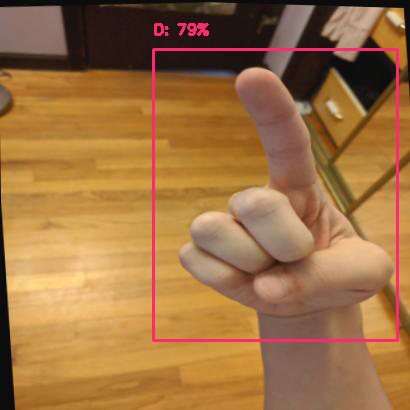

In [ ]:
#@title Run object detection and show the detection results

INPUT_IMAGE_URL = "https://storage.googleapis.com/sign_language_dataset2/D/D10_jpg.rf.8971201a8118bb6a6a70b219a2c0c1e3-2021-05-29T13%3A26%3A15.199Z.jpg" #@param {type:"string"}
DETECTION_THRESHOLD = 0.3 #@param {type:"number"}

TEMP_FILE = '/tmp/image.png'

!wget -q -O $TEMP_FILE $INPUT_IMAGE_URL
im = Image.open(TEMP_FILE)
im.thumbnail((512, 512), Image.ANTIALIAS)
im.save(TEMP_FILE, 'PNG')

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Run inference and draw detection result on the local copy of the original file
detection_result_image = run_odt_and_draw_results(
    TEMP_FILE, 
    interpreter, 
    threshold=DETECTION_THRESHOLD
)

# Show the detection result
Image.fromarray(detection_result_image)